In [1]:
import polars as pl
import plotly.express as px
import pandas as pd
from polars_visualization import pl_config as config
from freqSevEda import FreqSevEDA

# Data overview

- We have 1580 entries. Grouping by Loc ID and Año Póliza we saw that each policy is annual.

In [2]:
#path = r"C:\Users\abrah\OneDrive\Desktop\casoCAS\archivo\data\final-dataset.xlsx"
path2 = r"C:\Users\abrah\OneDrive\Desktop\final-dataset_rangos_V4.xlsx"
df = pl.read_excel(path2, sheet_name="Sheet 1")

with config():
    print(df)

shape: (1_580, 24)
| Loc ID | Año Póliza | Exposicion | Suma Asegurada | Prima   | Evento ID | Numero Siniestros | Mes  | Duración de la inundación (día… | Severidad de la inundación (es… | Precipitación (mm) | Incremento del Nivel del Río (… | Monto de siniestro | Latitud | Longitud | Ciudad        | Pais         | Codigo pais | Continente | Sub continente     | Rango_SA_mill | Rango_prima_miles | Rango_Precipitacion | Rango_Increment_Rio |
|--------|------------|------------|----------------|---------|-----------|-------------------|------|---------------------------------|---------------------------------|--------------------|---------------------------------|--------------------|---------|----------|---------------|--------------|-------------|------------|--------------------|---------------|-------------------|---------------------|---------------------|
| loc001 | 2,014      | 1          | 87,223,100     | 659,145 | null      | 0                 | null | null                    

In [3]:
eda = FreqSevEDA(df, exposure="Exposicion", claimNb="Numero Siniestros", claimAmount="Monto de siniestro")
eda.interactive_graph()

Dropdown(description='Columns:', options=('-', 'Loc ID', 'Año Póliza', 'Exposicion', 'Suma Asegurada', 'Prima'…

Output()

c:\Users\abrah\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning

c:\Users\abrah\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning:

KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.



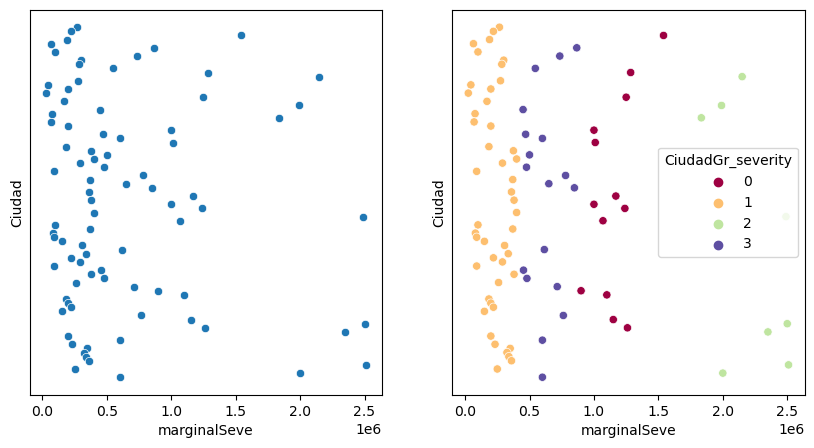

In [6]:
eda.show_clusters("Ciudad",4,show_labels= False, style = "severity")

# Description by columns

- We have negative values for TIV (Is this a mistake?) how should we deal with those values? We have only one location with negative TIV loc068. In this case we will take absolute value of the TIV column, in that way we don't lose information.
- Information between years 2014 and 2023
- Is premium in USD dolars?
- Duration floods between 4 and 10 days
- Severity value between 2 and 5. Why we don't have value 1?
- Precipitation between 100 mm and 310 mm
- Raising of river between 1.2 M and 4.5 M

In [ ]:
with config():
    print(df.describe())

#lets fix TIV values 

df = df.with_columns(pl.col("Suma Asegurada").abs())


# Information against Año Póliza

- Precipitación Promedio per years tends to increase

In [13]:
(df.group_by("Continente").agg(pl.col("Exposicion").sum().alias("Exposicion"),
                              pl.col("Suma Asegurada").sum(),
                              pl.col("Prima").sum().alias("Prima Ganada"),
                              pl.col("Evento ID").drop_nulls().n_unique().alias("Número Eventos"),
                              pl.col("Numero Siniestros").sum(),
                              pl.col("Duración de la inundación (días)").mean().alias("Duración Promedio"),
                              pl.col("Severidad de la inundación (escala 1-5)").mean().alias("Magnitud Inundaciones Promedio"),
                              pl.col("Precipitación (mm)").mean().alias("Precipitación Promedio"),
                              pl.col("Incremento del Nivel del Río (m)").mean().alias("Incremento Promedio"),
                              pl.col("Monto de siniestro").sum().alias("Incurrido"))
                         .with_columns((pl.col("Incurrido")/pl.col("Prima Ganada")).alias("Indice de Siniestralidad"),
                                       (pl.col("Prima Ganada")/pl.col("Suma Asegurada")*1000).alias("Tasa por Mil"),
                                       (pl.col("Incurrido")/pl.col("Suma Asegurada")).alias("TPR"),
                                       (pl.col("Numero Siniestros")/pl.col("Exposicion")).alias("Frecuencia"),
                                       (pl.col("Incurrido")/pl.col("Numero Siniestros")).alias("Severidad"))
                         .with_columns((pl.col("Frecuencia")*pl.col("Severidad")).alias("Prima Pura"))
                         .with_columns((pl.col("Prima Pura")/pl.col("Prima Ganada")).alias("proportion"))
                         .sort(by = "Prima Pura", descending=False))


Continente,Exposicion,Suma Asegurada,Prima Ganada,Número Eventos,Numero Siniestros,Duración Promedio,Magnitud Inundaciones Promedio,Precipitación Promedio,Incremento Promedio,Incurrido,Indice de Siniestralidad,Tasa por Mil,TPR,Frecuencia,Severidad,Prima Pura,proportion
str,i64,i64,i64,u32,i64,f64,f64,f64,f64,i64,f64,f64,f64,f64,f64,f64,f64
"""Africa""",250,25862436150,147605322,10,35,5.514286,3.228571,154.571429,1.908571,6890000,0.046679,5.707325,0.000266,0.14,196857.142857,27560.0,0.000187
"""Americas""",500,74477247970,440317884,20,60,5.75,3.266667,173.666667,2.215,24730000,0.056164,5.912113,0.000332,0.12,412166.666667,49460.0,0.000112
"""Oceania""",250,55085584211,303895922,10,31,5.83871,3.290323,181.612903,2.251613,12870000,0.04235,5.516796,0.000234,0.124,415161.290323,51480.0,0.000169
"""Europe""",300,67309035570,393485471,13,34,7.147059,3.823529,201.470588,2.623529,19400000,0.049303,5.845953,0.000288,0.113333,570588.235294,64666.666667,0.000164
"""Asia""",280,118890771390,841335922,10,28,8.321429,4.678571,261.428571,3.789286,42990000,0.051097,7.076545,0.000362,0.1,1.5354e6,153535.714286,0.000182


(17571*(1.03)+ 0.2*17571)/(1-0.016-0.17-0.1)

In [16]:
27560/25862436150*1000


0.001065638203615246

In [17]:
153535.714/118890771390*1000

0.0012914014452505608

In [8]:
(17571*(1.03)+ 0.2*17571)/(1-0.016-0.17-0.1)

30269.369747899163

In [10]:
17571/5444474010*1000

0.0032273090050070788